In [19]:
## April 6 2017
## jefan
## GOAL: compute between-run similarity matrix in order to compare between-obj and within-obj similarity to test 
## for differentiation. Use run-wise map of betas from GLM for each object.
## On the 'sketchloop' machine, data are found in sketchloop02 directory at the same level as this 'neurosketch' 
## analysis directory, and are organized by subject.

import warnings
warnings.filterwarnings('ignore')

In [124]:
## import general modules
import numpy as np
import glob
import os
import scipy.stats as stats
from sklearn import metrics
import matplotlib
matplotlib.use("Pdf")
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *

## import imaging analysis specific modules
import brainiak
import nilearn
import nibabel

from sklearn.metrics.pairwise import pairwise_distances as pd
from sklearn import svm
import sklearn

In [213]:
# load in experimental design pickle file
import _pickle as cPickle

with open('morph_drawing_training_design.pkl', 'rb') as f:
    mdtd = cPickle.load(f, encoding='latin1') 
    
def get_object_index(morphline,morphnum):
    furniture_axes = ['bedChair', 'bedTable', 'benchBed', 'chairBench', 'chairTable', 'tableBench']
    car_axes = ['limoToSUV','limoToSedan','limoToSmart','smartToSedan','suvToSedan','suvToSmart']  
    furniture_items = ['bed','bench','chair','table']
    car_items = ['limo','sedan','smartcar','SUV']               
    endpoints = mdr_helpers.getEndpoints(morphline)
    morphnum = float(morphnum)
    whichEndpoint = int(np.round(morphnum/100))
    thing = endpoints[whichEndpoint]
    if morphline in furniture_axes:
        return furniture_items.index(thing)+1
    elif morphline in car_axes:
        return car_items.index(thing)+1    
    
def getEndpoints(morphline):    
    if morphline=='sedanMinivan':
        return ['sedan','minivan']
    elif morphline=='minivanSportscar':
        return ['minivan','sportscar']
    elif morphline=='sportscarSUV':
        return ['sportscar','SUV']
    elif morphline=='SUVMinivan':
        return ['SUV','minivan']
    elif morphline=='sportscarSedan':
        return ['sportscar','sedan']
    elif morphline=='sedanSUV':
        return ['sedan','SUV']
    elif morphline=='bedChair':
        return ['bed','chair']
    elif morphline=='bedTable':
        return ['bed','table']
    elif morphline=='benchBed':
        return ['bench','bed']
    elif morphline=='chairBench':
        return ['chair','bench']
    elif morphline=='chairTable':
        return ['chair','table']
    elif morphline=='tableBench':
        return ['table','bench']
    elif morphline=='limoToSUV':
        return ['limo','SUV']    
    elif morphline=='limoToSedan':
        return ['sedan','limo']  
    elif morphline=='limoToSmart':
        return ['limo','smartcar']  
    elif morphline=='smartToSedan':
        return ['smartcar','sedan']    
    elif morphline=='suvToSedan':
        return ['SUV','sedan']  
    elif morphline=='suvToSmart':
        return ['SUV','smartcar']  
    else:
        return ['A','B']          


In [206]:
# behavioral data from database
import pymongo as pm
from pymongo import MongoClient
conn = MongoClient('localhost', 20809)

DBNAME = conn['during_morph_drawing_recognition']
COLNAME = DBNAME['fmri3.files']
coll=COLNAME
DATADIR = 'neurosketch_data_3'

In [217]:
# #### test out extraction of trained and control object labels

# w = sub_dirs[0]
# these = coll.find({'wID': w}).sort('trialNum')   
# versionNum = these[0]['versionNum']

# design = [i for i in mdtd if i['version'] == int(versionNum)] # find which axes belong to which condition
# trained = design[0]['trained']
# near = design[0]['near']
# far1 = design[0]['far1']
# far2 = design[0]['far2']

# endpoints = getEndpoints(trained)
# print('trained: ' + str(endpoints))

# endpoints = getEndpoints(near)
# print('control: ' + str(endpoints))

trained: ['bench', 'bed']
control: ['chair', 'table']


In [175]:
## get list of subject directories
proj_dir = '/home/jefan/sketchloop02'
contents_dir = os.listdir(proj_dir)

sub_dirs = []
for i in contents_dir:
    try:
        if i.split('_')[1]=='neurosketch':
            sub_dirs.append(i)
    except:
        pass

sub_dirs = sorted(sub_dirs)

# issue with 1207161
sub_dirs = [s for s in sub_dirs if s != '1207161_neurosketch']

print(sub_dirs)
print(str(len(sub_dirs)) + ' subjects')

['0110171_neurosketch', '0110172_neurosketch', '0111171_neurosketch', '0112171_neurosketch', '0112172_neurosketch', '0112173_neurosketch', '0113171_neurosketch', '0115172_neurosketch', '0115174_neurosketch', '0117171_neurosketch', '0118171_neurosketch', '0118172_neurosketch', '0119171_neurosketch', '0119172_neurosketch', '0119173_neurosketch', '0119174_neurosketch', '0120171_neurosketch', '0120172_neurosketch', '0120173_neurosketch', '0123171_neurosketch', '0123173_neurosketch', '0124171_neurosketch', '0125171_neurosketch', '0125172_neurosketch', '1121161_neurosketch', '1130161_neurosketch', '1201161_neurosketch', '1202161_neurosketch', '1203161_neurosketch', '1206161_neurosketch', '1206162_neurosketch', '1206163_neurosketch', '1207162_neurosketch']
33 subjects


In [21]:
# do for single subject for now
this_sub = sub_dirs[0]

In [10]:
analysis1_path = os.path.join(proj_dir,s,'analysis','firstlevel')
analysis1_dirs = os.listdir(analysis1_path)
if 'glm4_recognition_run_1+.feat' in analysis1_dirs:
    print('Check to make sure you get rid of redundant/incomplete GLM folders for this subject')
print(sorted(analysis1_dirs))

['.gitignore', 'glm4_recognition_run_1.feat', 'glm4_recognition_run_2.feat', 'glm4_recognition_run_3.feat', 'glm4_recognition_run_4.feat', 'glm4_recognition_run_5.feat', 'glm4_recognition_run_6.feat', 'preproc_recognition_run_1.feat', 'preproc_recognition_run_2.feat', 'preproc_recognition_run_3.feat', 'preproc_recognition_run_4.feat', 'preproc_recognition_run_5.feat', 'preproc_recognition_run_6.feat', 'rois']


In [9]:
## glm output directories by run number
pre1 = 'glm4_recognition_run_3.feat'
pre2 = 'glm4_recognition_run_4.feat'
post1 = 'glm4_recognition_run_5.feat'
post2 = 'glm4_recognition_run_6.feat'

In [11]:
stats_path = os.path.join(proj_dir,s,'analysis','firstlevel',pre1,'stats')
contents_stats_dir = os.listdir(stats_path)
print(sorted(contents_stats_dir))

['cope1.nii.gz', 'cope2.nii.gz', 'cope3.nii.gz', 'cope4.nii.gz', 'dof', 'logfile', 'pe1.nii.gz', 'pe2.nii.gz', 'pe3.nii.gz', 'pe4.nii.gz', 'pe5.nii.gz', 'pe6.nii.gz', 'pe7.nii.gz', 'pe8.nii.gz', 'res4d.nii.gz', 'sigmasquareds.nii.gz', 'smoothness', 'threshac1.nii.gz', 'tstat1.nii.gz', 'tstat2.nii.gz', 'tstat3.nii.gz', 'tstat4.nii.gz', 'varcope1.nii.gz', 'varcope2.nii.gz', 'varcope3.nii.gz', 'varcope4.nii.gz', 'zstat1.nii.gz', 'zstat2.nii.gz', 'zstat3.nii.gz', 'zstat4.nii.gz']


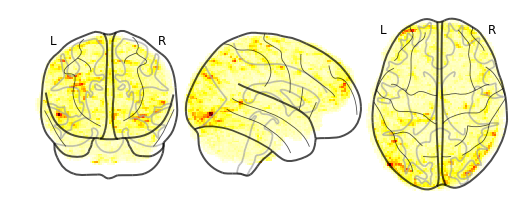

In [15]:
from nilearn import image
from nilearn import plotting
nifti_path = os.path.join(proj_dir,s,'analysis','firstlevel',post1,'stats','cope1.nii.gz')
plotting.plot_glass_brain(nifti_path)

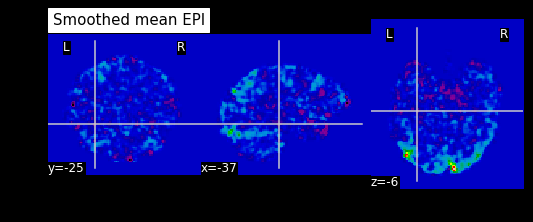

In [13]:
fmri_img = image.smooth_img(nifti_path,fwhm=3)
from nilearn.plotting import plot_epi
mean_img = image.mean_img(fmri_img)
plot_epi(mean_img, title='Smoothed mean EPI', cut_coords=[-37,-25,-6])

In [16]:
## load ROI mask
rois_path = os.path.join(proj_dir,s,'analysis','firstlevel','rois')
contents_rois = os.listdir(rois_path)
# print(sorted(contents_rois))

In [260]:
## cope numbering legend
## cope1 = 'bed'
## cope2 = 'bench'
## cope3 = 'chair'
## cope4 = 'table'

cope2obj = {'cope1':'bed','cope2':'bench', 'cope3':'chair','cope4':'table'}
obj2cope = {'bed':1,'bench':2, 'chair':3,'table':4}

def triple_sum(X):
    return sum(sum(sum(X)))

def get_mask_array(mask_path):
    mask_img = image.load_img(mask_path)
    mask_data = mask_img.get_data()
    num_brain_voxels = sum(sum(sum(mask_data==1)))
    return mask_data, num_brain_voxels
    
def load_roi_mask(subj,run_num,roi):
    mask_path = proj_dir + subj +'/analysis/firstlevel/rois/' + roi + '_func__' + str(run_num) + '_binarized.nii.gz'        
    mask_data, nv = get_mask_array(mask_path)
    return mask_data

def load_roi_mask_combined(subj,run_num,roi):
    if run_num in [1,2]:
        phase_num = '12'
    elif run_num in [3,4]:
        phase_num = '34'
    elif run_num in [5,6]:
        phase_num = '56'
    mask_path = proj_dir + '/' + subj +'/analysis/firstlevel/rois/' + roi + '_func_combined_' + phase_num + '_binarized.nii.gz'        
    mask_data, nv = get_mask_array(mask_path)
    return mask_data

def normalize(X):
    mn = X.mean(0)
    sd = X.std(0)
    X = X - mn
    X = X / np.maximum(sd, 1e-5)
    return X

def load_single_run_weights(subj,run_num,cope_num):
    nifti_path = proj_dir + '/' + subj + '/analysis/firstlevel/glm4_recognition_run_' + str(run_num) + \
                '.feat/stats/' + 'cope' + str(cope_num) + '.nii.gz'
    fmri_img = image.load_img(nifti_path)
    fmri_data = fmri_img.get_data()
    return fmri_data

def apply_mask(data,mask):
    return data[mask==1]

def load_data_and_apply_mask(subj,run_num,roi,cope_num):
    mask = load_roi_mask_combined(subj,run_num,roi)
    vol = load_single_run_weights(subj,run_num,cope_num)
    vec = apply_mask(vol,mask)
    return vec

def extract_obj_by_voxel_run_mat(this_sub,run_num, roi):
    cope1 = load_data_and_apply_mask(this_sub,run_num,roi,1)
    cope2 = load_data_and_apply_mask(this_sub,run_num,roi,2)
    cope3 = load_data_and_apply_mask(this_sub,run_num,roi,3)
    cope4 = load_data_and_apply_mask(this_sub,run_num,roi,4)
    return np.vstack((cope1,cope2,cope3,cope4))

def plot_phase_RSM(this_sub,roi,phase):
    '''
    e.g., plot_phase_RSM(this_sub,'fusiform','pre')
    '''
    if phase=='pre':
        mat1 = extract_obj_by_voxel_run_mat(this_sub,3,roi)
        mat2 = extract_obj_by_voxel_run_mat(this_sub,4,roi)
    elif phase=='post':
        mat1 = extract_obj_by_voxel_run_mat(this_sub,5,roi)
        mat2 = extract_obj_by_voxel_run_mat(this_sub,6,roi)        
    stacked = np.vstack((mat1,mat2))
    plt.matshow(np.corrcoef(stacked))
    plt.colorbar()

    
def extract_condition_by_voxel_run_mat(this_sub,run_num, roi):
    w = this_sub
    these = coll.find({'wID': w}).sort('trialNum')   
    versionNum = these[0]['versionNum']

    design = [i for i in mdtd if i['version'] == int(versionNum)] # find which axes belong to which condition
    trained = design[0]['trained']
    near = design[0]['near']
    far1 = design[0]['far1']
    far2 = design[0]['far2']

    Tep = getEndpoints(trained)
    Nep = getEndpoints(near)
    condorder = Tep + Nep

    slot1 = load_data_and_apply_mask(this_sub,run_num,roi,obj2cope[condorder[0]])
    slot2 = load_data_and_apply_mask(this_sub,run_num,roi,obj2cope[condorder[1]])
    slot3 = load_data_and_apply_mask(this_sub,run_num,roi,obj2cope[condorder[2]])
    slot4 = load_data_and_apply_mask(this_sub,run_num,roi,obj2cope[condorder[3]])
    return np.vstack((slot1,slot2,slot3,slot4))
    
    
def remove_nans(array):
    return array[~np.isnan(array)]

def rmse(a):
    return np.sqrt(np.mean(map(np.square,a)))

def betwitdist(a,b,ab):
    return ab/np.sqrt(0.5*(a**2+b**2))

def norm_hist(data,bins):
    weights = np.ones_like(data)/float(len(data))
    plt.hist(data, bins=bins, weights=weights)
    
def compare_btw_wit_obj_similarity_across_runs(this_sub,phase,roi):
    if phase=='pre':
        mat1 = extract_obj_by_voxel_run_mat(this_sub,3,roi)
        mat2 = extract_obj_by_voxel_run_mat(this_sub,4,roi)
    elif phase=='post':
        mat1 = extract_obj_by_voxel_run_mat(this_sub,5,roi)
        mat2 = extract_obj_by_voxel_run_mat(this_sub,6,roi)        
    fAB = np.vstack((mat1,mat2)) # stack feature matrices
    DAB = sklearn.metrics.pairwise.pairwise_distances(fAB, metric='correlation') # square matrix, where off-diagblock is distances *between* fA and fB vectors
    offblock = DAB[:len(mat1),range(len(mat1),shape(DAB)[1])]
    wit_obj = DAB[:len(mat1),range(len(mat1),shape(DAB)[1])].diagonal()
    btw_obj = np.hstack((offblock[np.triu_indices(shape(offblock)[0],k=1)],offblock[np.tril_indices(shape(offblock)[0],k=-1)]))
    wit_mean = wit_obj.mean()
    btw_mean = btw_obj.mean()
    return wit_mean,btw_mean

def compare_btw_wit_cond_similarity_across_runs(this_sub,phase,roi):

    if phase=='pre':
        mat1 = extract_condition_by_voxel_run_mat(this_sub,3,'fusiform')
        mat2 = extract_condition_by_voxel_run_mat(this_sub,4,'fusiform')
    elif phase=='post':
        mat1 = extract_condition_by_voxel_run_mat(this_sub,5,'fusiform')
        mat2 = extract_condition_by_voxel_run_mat(this_sub,6,'fusiform')

    fAB = np.vstack((mat1,mat2)) # stack feature matrices
    DAB = sklearn.metrics.pairwise.pairwise_distances(fAB, metric='correlation') # square matrix, where off-diagblock is distances *between* fA and fB vectors
    offblock = DAB[:len(mat1),range(len(mat1),shape(DAB)[1])]

    trained_witobj = offblock.diagonal()[:2]
    control_witobj = offblock.diagonal()[2:]
    trained_btwobj = np.array([offblock[:2,:2][0,1], offblock[:2,:2][1,0]])
    control_btwobj = np.array([offblock[2:,2:][0,1],offblock[2:,2:][1,0]])

    trawit_mean = trained_witobj.mean()
    conwit_mean = control_witobj.mean()
    trabtw_mean = trained_btwobj.mean()
    conbtw_mean = control_btwobj.mean()
    return trawit_mean,conwit_mean,trabtw_mean,conbtw_mean

In [261]:
trawit_mean_pre,conwit_mean_pre,trabtw_mean_pre,conbtw_mean_pre = compare_btw_wit_cond_similarity_across_runs(this_sub,'pre','fusiform')
trawit_mean_post,conwit_mean_post,trabtw_mean_post,conbtw_mean_post = compare_btw_wit_cond_similarity_across_runs(this_sub,'post','fusiform')



In [263]:
tradiff_pre = trabtw_mean_pre - trawit_mean_pre
condiff_pre = conbtw_mean_pre - conwit_mean_pre

tradiff_post = trabtw_mean_post - trawit_mean_post
condiff_post = conbtw_mean_post - conwit_mean_post

print('Trained Btw-Wit Post-Pre: ' + str(tradiff_post-tradiff_pre))
print('Control Btw-Wit Post-Pre: ' + str(condiff_post-condiff_pre))  

In [164]:
wit_pre,btw_pre = compare_btw_wit_obj_similarity_across_runs(this_sub,'pre','fusiform')
wit_post,btw_post = compare_btw_wit_obj_similarity_across_runs(this_sub,'post','fusiform')

diff_pre = btw_pre-wit_pre 
diff_post = btw_post-wit_post

print(wit_pre,btw_pre,diff_pre)
print(wit_post,btw_post,diff_post)


0.604173913793 0.593622144969 -0.0105517688238
0.713256874684 0.731001600142 0.0177447254572


In [194]:
Witpre = []
Btwpre = []
Witpost = []
Btwpost = []
Diffpre = []
Diffpost = []

ROIs = ['V1','fusiform','paraphippo','IT','LOC','occitemp']
ROIs = ROIs[:3]

for roi in ROIs:
    print(roi)
    _Witpre = []
    _Btwpre = []
    _Witpost = []
    _Btwpost = []
    _Diffpre = []
    _Diffpost = []
    for s in sub_dirs[:5]:
        roi = 'occitemp'
        wit_pre,btw_pre = compare_btw_wit_obj_similarity_across_runs(s,'pre',roi)
        wit_post,btw_post = compare_btw_wit_obj_similarity_across_runs(s,'post',roi)
        _Diffpre.append(btw_pre-wit_pre)
        _Diffpost.append(btw_post-wit_post)    
        _Witpre.append(wit_pre)
        _Btwpre.append(btw_pre)
        _Witpost.append(wit_post)
        _Btwpost.append(btw_post)    

    _Witpre,_Btwpre,_Witpost,_Btwpost,_Diffpre,_Diffpost = map(np.array,[_Witpre,_Btwpre,_Witpost,_Btwpost,_Diffpre,_Diffpost])
    
    if len(Witpre)==0:
        Witpre = _Witpre
        Btwpre = _Btwpre
        Witpost = _Witpost
        Btwpost = _Btwpost
        Diffpre = _Diffpre
        Diffpost = _Diffpost
    else:
        Witpre = np.vstack((Witpre,_Witpre))
        Btwpre = np.vstack((Btwpre,_Btwpre))   
        Witpost = np.vstack((Witpost,_Witpost))
        Btwpost = np.vstack((Btwpost,_Btwpost)) 
        Diffpre = np.vstack((Diffpre,_Diffpre))
        Diffpost = np.vstack((Diffpost,_Diffpost))         

V1
fusiform
paraphippo
